# Data Gathering

In [1]:
from pathlib import Path
from datetime import datetime
import sys


# Define the base directory
base_dir = Path.cwd().resolve().parents[1]

# Define subdirectories
data_dir = base_dir / "data"
model_dir = base_dir / "models"
notebooks_dir = base_dir / "notebooks"

# Append base_dir to sys.path
sys.path.append(str(base_dir))

from axyom_utilities.data_extraction import extract_data

X_train, y_train, X_test, X_orig, y_orig = extract_data(data_dir, log_transform=True)


In [8]:
import pandas as pd
import glob
from pathlib import Path

def get_meta_data(meta_data_dir, oof_joker="*_oof.csv", test_joker="*_test.csv"):
    meta_data_dir = Path(meta_data_dir)
    # Define file patterns for OOF and test predictions
    oof_catch = str(meta_data_dir / oof_joker)
    test_catch = str(meta_data_dir / test_joker)
    
    oof_files = sorted(glob.glob(oof_catch))  # Sorted for consistency
    test_files = sorted(glob.glob(test_catch))  # Sorted for consistency
    
    #print(test_files)

    # Ensure the number of files matches
    assert len(oof_files) == len(test_files), "Mismatch in the number of OOF and test files."

    # Function to load and rename files with prefixes
    def load_and_prefix(files, prefix):
        dfs = []
        for file in files:
            # Extract only the base name without directory and suffix
            model_name = Path(file).stem.replace("_oof", "").replace("_test", "")
            df = pd.read_csv(file)
            #print(df.head(4))
            df.columns = [f"{prefix}{model_name}_F{i+1}" for i in range(df.shape[1])]
            dfs.append(df)
        return pd.concat(dfs, axis=1, ignore_index=True)

    # Load OOF and test predictions with identical features
    X_meta_train = load_and_prefix(oof_files, prefix="")
    X_meta_test = load_and_prefix(test_files, prefix="")

    # Ensure the columns are identical between train and test
    X_meta_test.columns = X_meta_train.columns

    # Check the shapes
    print(f"Meta-train shape: {X_meta_train.shape}")
    print(f"Meta-test shape: {X_meta_test.shape}")
    
    return X_meta_train, X_meta_test

# Example usage
#X_meta_train, X_meta_test = get_meta_data("notebooks/Ensemble Catboost XGBoost LGBM")

# mikail
X_meta_train_mikail, X_meta_test_mikail = get_meta_data(notebooks_dir/"Ensemble Catboost XGBoost LGBM")

def file_exists(filepath):
    file_path = Path(filepath)
    if not file_path.is_file():
        raise FileNotFoundError(f"The file '{filepath}' does not exist.")

def get_oof_test(filename, column_name):        
    df = pd.read_csv(filename)
    
    if df.shape[1] > 1:
        # If multiple columns, get last one
        df = pd.DataFrame(df.iloc[:, 1], columns=[column_name])
        
    # If single column, assign the provided column name
    df.columns = [column_name]
    return df

# Axyom
lgbm2_train = get_oof_test(notebooks_dir/"LGBM_v2\\1.0313+-0.0008\\oof_preds.csv", "LGBM_v2_axyom")
lgbm2_test = get_oof_test(notebooks_dir/"LGBM_v2\\1.0313+-0.0008\\test_preds.csv", "LGBM_v2_axyom")

autogluon_v2_train = get_oof_test(notebooks_dir/"Autogluon_v2\\AutogluonModels\\ag-20241225_165244\\oof_preds.csv", "autogluon_v2_axyom")
autogluon_v2_test = get_oof_test(notebooks_dir/"Autogluon_v2\\AutogluonModels\\ag-20241225_165244\\test_preds.csv", "autogluon_v2_axyom")

catboost_v2_train = get_oof_test(notebooks_dir/"Catboost_nonlog_feature\\1.0309+-0.0008\\oof_preds.csv", "catboost_v2_axyom")
catboost_v2_test = get_oof_test(notebooks_dir/"Catboost_nonlog_feature\\1.0309+-0.0008\\test_preds.csv", "catboost_v2_axyom")

xgboost_v2_train = get_oof_test(notebooks_dir/"XGBoost v2/1.0312+-0.0007\\oof_preds.csv", "xgboost_v2_axyom")
xgboost_v2_test = get_oof_test(notebooks_dir/"XGBoost v2/1.0312+-0.0007\\test_preds.csv", "xgboost_v2_axyom")

# arno
catboost_kaggle_train = get_oof_test(notebooks_dir/"Kaggle computed ensemble\\cleaned_catboost_oof_preds.csv", "catboost_kaggle")
catboost_kaggle_test = get_oof_test(notebooks_dir/"Kaggle computed ensemble\\cleaned_catboost_test_preds.csv", "catboost_kaggle")

lgbm_kaggle_train = get_oof_test(notebooks_dir/"Kaggle computed ensemble\\cleaned_lgbm_oof_preds.csv", "lgbm_kaggle")
lgbm_kaggle_test = get_oof_test(notebooks_dir/"Kaggle computed ensemble\\cleaned_lgbm_test_preds.csv", "lgbm_kaggle")

xgb_kaggle_train = get_oof_test(notebooks_dir/"Kaggle computed ensemble\\cleaned_xgb_oof_preds.csv", "xgb_kaggle")
xgb_kaggle_test = get_oof_test(notebooks_dir/"Kaggle computed ensemble\\cleaned_xgb_test_preds.csv", "xgb_kaggle")

# CONCATENATION
X_meta_train = pd.concat([
    X_meta_train_mikail, 
    lgbm2_train, 
    autogluon_v2_train, 
    catboost_v2_train, 
    xgboost_v2_train,
    catboost_kaggle_train, 
    lgbm_kaggle_train, 
    xgb_kaggle_train
], axis=1, ignore_index=True)
X_meta_test =  pd.concat([
    X_meta_test_mikail, 
    lgbm2_test,
    autogluon_v2_test, 
    catboost_v2_test,
    xgboost_v2_test, 
    catboost_kaggle_test, 
    lgbm_kaggle_test, 
    xgb_kaggle_test
], axis=1, ignore_index=True)


Meta-train shape: (1200000, 23)
Meta-test shape: (1600000, 23)


In [9]:
X_meta_test

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,6.740645,6.736749,6.747006,NaN,NaN,NaN,NaN,6.755058,6.797357,6.797910,...,NaN,NaN,6.790695,6.816126,6.806002,6.788706,6.798331,6.727067,6.795613,6.796549
1,6.818444,6.820230,6.820429,NaN,NaN,NaN,NaN,6.812776,6.850879,6.853126,...,NaN,NaN,6.805711,6.807981,6.807899,6.857188,6.825700,6.798005,6.813113,6.813832
2,6.693392,6.697543,6.704042,NaN,NaN,NaN,NaN,6.697973,6.676384,6.683895,...,NaN,NaN,6.708835,6.717174,6.707768,6.751060,6.708321,6.706616,6.719627,6.710978
3,6.708020,6.705030,6.701479,NaN,NaN,NaN,NaN,6.698512,6.690662,6.694770,...,NaN,NaN,6.708548,6.696451,6.703429,6.718030,6.707902,6.703559,6.688500,6.712946
4,6.686487,6.688096,6.681891,NaN,NaN,NaN,NaN,6.695833,6.693433,6.692232,...,NaN,NaN,6.705325,6.690142,6.699025,6.663495,6.686766,6.691903,6.685406,6.683112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599995,NaN,NaN,NaN,6.865649,6.883510,6.862507,6.870258,NaN,NaN,NaN,...,6.891109,6.894202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1599996,NaN,NaN,NaN,6.625642,6.568341,6.629498,6.616631,NaN,NaN,NaN,...,6.552966,6.557660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1599997,NaN,NaN,NaN,6.740598,6.755071,6.740377,6.741992,NaN,NaN,NaN,...,6.765836,6.754628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1599998,NaN,NaN,NaN,6.830115,6.877386,6.817793,6.819165,NaN,NaN,NaN,...,6.819287,6.831121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Meta Training

[I 2024-12-27 00:20:16,982] A new study created in memory with name: no-name-a01f6ec5-4d20-4f25-9eaa-1b4eaab73d8d
[I 2024-12-27 00:20:17,109] Trial 0 finished with value: 1.0307675893735653 and parameters: {'weight_0': 0.17550018418935043, 'weight_1': 0.9584282057588903, 'weight_2': 0.4807600674514957, 'weight_3': 0.9316951250647968, 'weight_4': 0.16811678555493492, 'weight_5': 0.9454176749317404, 'weight_6': 0.8597117882388684, 'weight_7': 0.7239137387193948, 'weight_8': 0.3615203970420694, 'weight_9': 0.691778712539979, 'weight_10': 0.6249220604114092, 'weight_11': 0.6124077028287419, 'weight_12': 0.3011748335415464, 'weight_13': 0.45834370990728934, 'weight_14': 0.6097445194562169, 'weight_15': 0.6861684508874453, 'weight_16': 0.8808211459345914, 'weight_17': 0.6126678143790331, 'weight_18': 0.8346880401157766}. Best is trial 0 with value: 1.0307675893735653.
[I 2024-12-27 00:20:17,242] Trial 1 finished with value: 1.0307973540632966 and parameters: {'weight_0': 0.697078838182546, '

Optimized Weights: [0.02430897 0.00030722 0.04195954 0.03753093 0.03079493 0.00954741
 0.02903411 0.01454292 0.05667007 0.05164019 0.10783199 0.06176625
 0.02870408 0.13128759 0.02576083 0.22548379 0.0044809  0.00658583
 0.11176245]
Best RMSE: 1.029952356433932


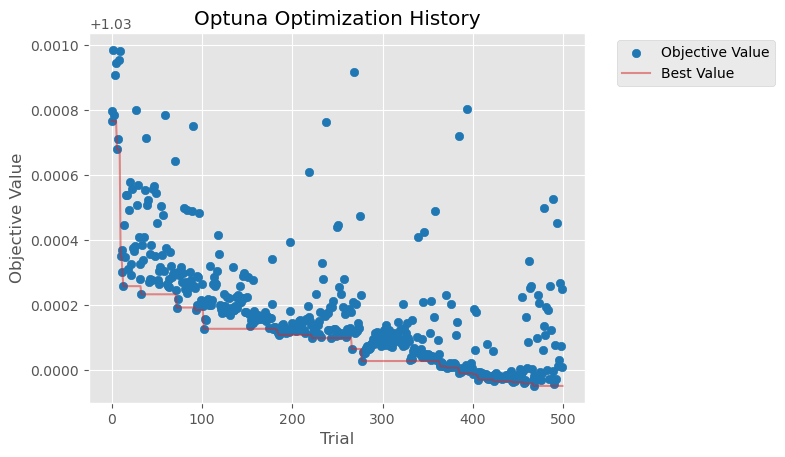

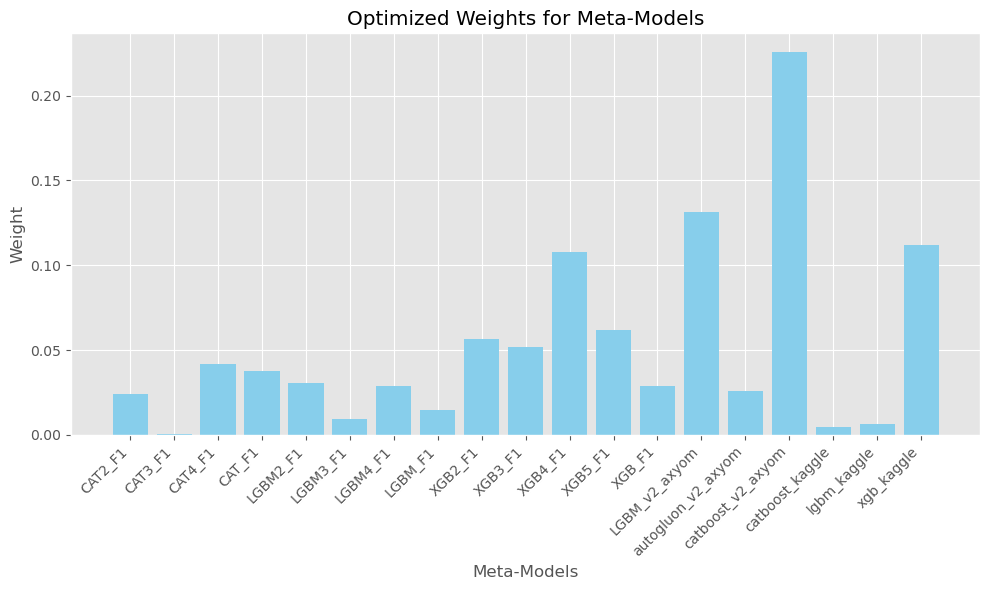

In [16]:
import optuna
import numpy as np
from sklearn.metrics import mean_squared_error
from optuna.visualization.matplotlib import (
    plot_optimization_history, 
    plot_param_importances, 
    plot_slice
)
import matplotlib.pyplot as plt

def optimize_ensemble_weights(X_meta_train, X_meta_test, y_train, n_trials=100):
    """
    Optimize ensemble weights for a given set of meta-features using Optuna.
    
    Parameters:
        X_meta_train (pd.DataFrame): OOF predictions (meta-features) for training.
        X_meta_test (pd.DataFrame): Predictions for the test set (meta-features).
        y_train (pd.Series): True target values for training.
        n_trials (int): Number of trials for Optuna optimization.
    
    Returns:
        dict: Optimized weights for each meta-model.
        np.ndarray: Final predictions on the test set.
    """
    # Define the objective function
    def objective(trial):
        num_models = X_meta_train.shape[1]
        weights = [trial.suggest_float(f"weight_{i}", 0, 1) for i in range(num_models)]
        weights = np.array(weights) / sum(weights)  # Normalize weights to sum to 1
        ensemble_preds = (X_meta_train.values * weights).sum(axis=1)
        rmse = np.sqrt(mean_squared_error(y_train, ensemble_preds))
        return rmse

    # Initialize and optimize the study
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)

    # df = study.trials_dataframe()
    # print(df)  

    # Retrieve the best weights
    best_weights = study.best_params
    normalized_weights = np.array([best_weights[f"weight_{i}"] for i in range(len(best_weights))])
    normalized_weights /= normalized_weights.sum()

    # Generate predictions for the test set
    test_preds = (X_meta_test.values * normalized_weights).sum(axis=1)

    # Print optimization results
    print("Optimized Weights:", normalized_weights)
    print("Best RMSE:", study.best_value)

    # Plot optimization history
    plot = plot_optimization_history(study)
    plt.title("Optuna Optimization History")
    plt.show()
    
    weight_mapping = dict(zip(X_meta_train.columns, normalized_weights))
    
    # Plot bar chart of weights
    plt.figure(figsize=(10, 6))
    plt.bar(weight_mapping.keys(), weight_mapping.values(), color="skyblue")
    plt.title("Optimized Weights for Meta-Models")
    plt.xlabel("Meta-Models")
    plt.ylabel("Weight")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    return best_weights, test_preds, study.best_value

# Assuming meta_features (training meta-features), meta_predictions (test meta-features),
# and y_train (true target values) are already defined.
optimized_weights, test_preds, weight_ensembling_score = optimize_ensemble_weights(
    X_meta_train=X_meta_train,
    X_meta_test=X_meta_test,
    y_train=y_train,
    n_trials=750
)

In [4]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from axyom_utilities.training import train_model_cv
from axyom_utilities.wrappers import RidgeRegressorWrapper, LGBMRegressorWrapper

# Neural Network class
class NeuralNetwork:
    def __init__(self, input_dim, learning_rate=0.001):
        self.model = Sequential([
            Dense(128, activation='relu', input_dim=input_dim),
            Dense(64, activation='relu'),
            Dense(1)
        ])
        self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    
    def fit(self, X_train, y_train, epochs=50, batch_size=32, verbose=0):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    def predict(self, X):
        return self.model.predict(X).flatten().ravel()

# Initialize models
meta_models = {
    "Ridge": RidgeRegressorWrapper(alpha=1.0, random_state=42),
    "LightGBM": LGBMRegressorWrapper(random_state=42, verbose=-1)
    #"NeuralNetwork": NeuralNetwork(input_dim=X_meta_train.shape[1])
}

# Train and evaluate models
results = {}
for name, model in meta_models.items():
    r = train_model_cv(model, X_meta_train, y_train, X_meta_test, cv_splits=10)
    
    oof_preds = r['oof_preds']
    test_preds = r['test_preds']
    score = np.mean(r['cv_scores'])
    
    results[name] = {"oof_preds": oof_preds, "test_preds": test_preds, "score":score}
    print(f"{name} OOF RMSE: {score:.6f}")

# Compare stacking methods
# for method, result in results.items():
#     print(f"{method}: OOF RMSE = {result['oof_rmse']:.4f}")
# Find the best model
# best_model = max(results.items(), key=lambda x: x[1]["score"])
# best_name, best_data = best_model

# # Extract relevant details
# best_oof_preds = best_data["oof_preds"]
# best_test_preds = best_data["test_preds"]

# print(f"Best Model Name: {best_name}")
# print(f"OOF Predictions: {best_oof_preds}")
# print(f"Test Predictions: {best_test_preds}")


Training fold 1...
Fold 1 RMSE: 1.0338
Training fold 2...
Fold 2 RMSE: 1.0287
Training fold 3...
Fold 3 RMSE: 1.0284
Training fold 4...
Fold 4 RMSE: 1.0325
Training fold 5...
Fold 5 RMSE: 1.0320
Training fold 6...
Fold 6 RMSE: 1.0271
Training fold 7...
Fold 7 RMSE: 1.0322
Training fold 8...
Fold 8 RMSE: 1.0312
Training fold 9...
Fold 9 RMSE: 1.0337
Training fold 10...
Fold 10 RMSE: 1.0273
Mean CV RMSE: 1.0307 ± 0.0025
LightGBM OOF RMSE: 1.030690


In [5]:
results

{'LightGBM': {'oof_preds': array([6.86604487, 6.61481786, 6.73409579, ..., 5.26747052, 6.79981696,
         5.67555292]),
  'test_preds': array([6.78876534, 6.82375446, 6.70490667, ..., 6.75423886, 6.8195356 ,
         6.71713966]),
  'score': 1.0306895513430856}}

# Submission

In [17]:
# test_preds = results['LightGBM']['test_preds']
# score = results['LightGBM']['score']
test_preds
score = weight_ensembling_score

In [18]:
if True:
    y_pred = np.maximum(0, np.expm1(test_preds))

    submission = pd.DataFrame({
        'id': X_test.index,  
        'Premium Amount': y_pred
    })

    FILE_PATH = f"Stacking_v3_{score:.4f}.csv"

    submission.to_csv(FILE_PATH, index=False)